# Instrumental Variables

This lecture is heavily based on the great [Python Causality handbook](https://github.com/matheusfacure/python-causality-handbook)

## Going Around Omitted Variable Bias

One way to control for Omitted Variable Bias is adding the omitted variable into our model. However, that is not always possible. 

Let's go back to our model for effect of education on wage:

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}Ability_i + u_i
$

To figure out the causal effect of education $\kappa$ on $log(hwage)$ we need to control for ability factors $Ability_i$. If we don't, we would have some bias: ability is a confounder, causing both the treatment, education, and the outcome, earnings.

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

# External libraries
# Requires a graphviz installation 
# (brew install graphviz on macOS)
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

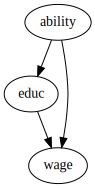

In [6]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

One way to avoid this is to control for constant levels of ability when measuring the effect of education on wage. 

We could do that by including ability in our linear regression model. 

However, we don't have good measurements of ability. The best we have are some very questionable proxies, like IQ.

But all is not lost. Here is where Instrumental Variables enters the picture. The idea of IV is to find another variable that causes the treatment and it is only correlated with the outcome through the treatment. Another way of saying this is that this instrument $Z_i$ is uncorrelated with $Y_0$, but it is correlated with $T$. This is sometimes referred to as the exclusion restriction.

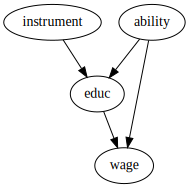

In [7]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

If we have such a variable, we can recover the causal effect with what we will see as the IV formula. 

To do so, let's think about the ideal equation we want to run. 

Using more general terms like $T$ for the treatment and $W$ for the confounders, here is want we want:

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

However, we don't have data on $W$, so all we can run is

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

Since $W$ is a confounder, $Cov(T, v) \neq 0$. 

In our example, this would be saying that ability is correlated with education. 

If this is the case, running the short regression would yield a biased estimate for $kappa$ due to omitted variables. 

# Behold the magic of IV

Since the instrument Z is only correlated with the outcome through T, this implies that $Cov(Z,v) = 0$, otherwise there would be a second path from Z to Y through W.

What this is showing to us is more subtle than most people appreciate. 

By writing IV like this, we are saying, "look, it's hard to find the impact of T on Y due to confounders. But I can easily find the impact of Z on Y, since there is nothing that causes Z and Y (exclusion restriction). However, I'm interested in the impact of T on Y, not Z on Y. So, I'ma estimate the easy effect of Z on Y and **scale it by the effect of Z on T**, to convert the effect to T units instead of Z units". 

## Quarter of Birth and the Effect of Education on Wage

So far, we've been treating these instruments as some magical variable $Z$ which have the miraculous propriety of only affecting the outcome through the treatment. To be honest, good instruments are so hard to come by that we might as well consider them miracles. 

Still, we do have some interesting examples of instruments to make things a little more concrete. We will again try to estimate the effect of education on wage. To do so, we will use the person's quarter of birth as the instrument Z.

This idea takes advantage of US compulsory attendance law. Usually, they state that a kid must have turned 6 years by January 1 of the year they enter school. For this reason, kids that are born at the beginning of the year will enter school at an older age. Compulsory attendance law also requires students to be in school until they turn 16, at which point they are legally allowed to drop out. The result is that people born later in the year have, on average, more years of education than those born in the beginning of the year.

![img](./img/qob.png)

If we accept that quarter of birth is independent of the ability factor, that is, it does not confound the impact of education on wage, we can use it as an instrument. In other words, we need to believe that quarter of birth has no impact on wage, other than through its impact on education. If you don't believe in astrology, this is a very compelling argument.

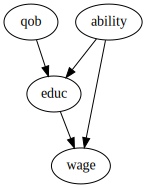

In [8]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

To perform this analysis, we can use data from three decennial census, the same data used by [Angrist and Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991) in their article about IV. This dataset has information on log wages, our outcome variable, and years of schooling, our treatment variable. It also has data on quarter of birth, our instrument, and additional controls, such as year of birth and state of birth. 

In [9]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## The 1st Stage

Before we use quarter of birth as an instrument, we need to make sure it is a valid one. This implies arguing in favor of the two Instrumental Variables assumptions:

1. $Cov(Z, T) \neq 0$. This is saying that we should have a strong 1st stage, or that the instrument indeed impacts the treatment variable.
2. $Y \perp Z | T $. This is the exclusion restriction, stating that the instrument Z only affects the outcome Y through the treatment T. 

The first assumption is fortunately verifiable. We can see from data that \\(Cov(Z, T)\\) is not zero. In our example, if quarter of birth is indeed an instrument like we've said, we should expect individuals born in the last quarter of the year to have slightly more time of education than those born in the beginning of the year. Before running any statistical test to verify this, let's just plot our data and see it with our own eyes.

In [10]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))
group_data.head(3)

,year_of_birth,quarter_of_birth,log_wage,years_of_schooling,time_of_birth
0,30.0,1.0,5.889133,12.280405,30.25
1,30.0,2.0,5.898007,12.428418,30.50
2,30.0,3.0,5.909365,12.491860,30.75


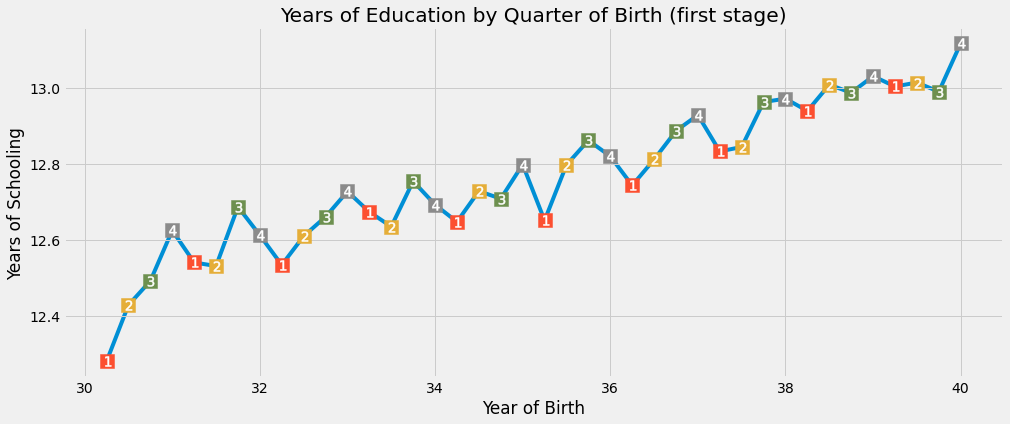

In [11]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

Remarkably, there is a seasonal pattern on the years of schooling that follows the quarter of the year. Visually, we can see that those born in the first quarter of the year have almost always less education than those born in the last quarter (once we control for the year of birth, after all, those born in later years have more education, in general).

To be a bit more rigorous, we can run the 1st stage as a linear regression. We will first convert the quarter of birth to dummy variables:

In [12]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


For simplicity, let's only use the last quarter, q4, as the instrument for now. We will run a regression of years of schooling, the treatment, on quarter of birth, the instrument. This will show us if indeed quarter of birth positively affects time of education like we saw in the plot above. We also need to control for years of birth here and we will add state of birth as an additional control.

In [18]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272785928
q4 p-value:,  5.4648294166376076e-15


It looks like those born in the last quarter of the year have, on average, 0.1 more years of education than those born in other quarters of the year. The p-value is close to zero. This closes the case on whether quarter of birth causes more or less years of schooling.

## The Reduced Form

Unfortunately, we can't verify the second IV condition. We can only argue in favor of it. We can express our belief that quarter of birth does not influence potential earnings. In other words, the time people are born is not an indication of their personal ability or any other factor that can cause a difference in earnings, other than the effect on education. A good way of doing that is to say that the quarter of birth is as good as randomly assigned when we are thinking about it's impact on earnings. (It isn't random. There is evidence that people tend to conceive around the end of the summer or around some sort of holiday. But I can't think of any good reason that this pattern also affects income in any way other than through education).

Having argued in favor of the exclusion restriction, we can proceed to run the reduced form. The reduced form aims at figuring out how the instrument influences the outcome. Since, by assumption, all this influence is due to the effect on treatment, this will shed some light into how the treatment affects the outcome. Once again, let's evaluate this visually before getting serious with regression. 

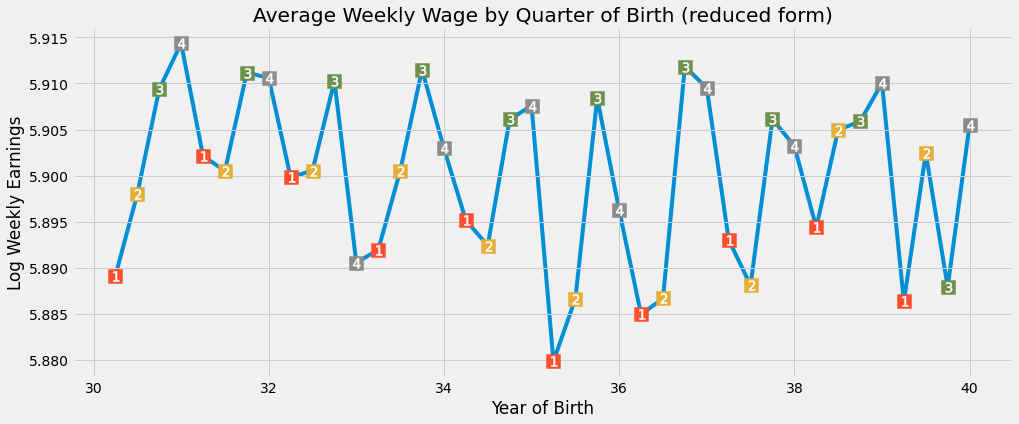

In [14]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

Once again, we can see a seasonal pattern on earnings by the quarter of birth. Those born later on the year have slightly higher income than those born in the beginning of the year. To test this hypothesis, we will again regress the instrumental q4 on log wage. We will also add the same additional controls as in the 1st stage:

In [15]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260138794
q4 p-value:,  0.0014949127183682181


Once again, we have a significant result. Those born in the last quarter of the year have, on average, 0.8% higher wages. This time, the p-value is not so close to zero as before, but it's still pretty significant, being just 0.0015. 

# The IV Regression

We got the `years_of_schooling_fitted` from the "first stage" regression $years\_school \approx year\_birth + state\_birth$

Now, we inject the **predicted value from the first stage** as the coefficient of interest in the second stage:

In [20]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

print(iv_by_hand.params["years_of_schooling_fitted"])
print(iv_by_hand.pvalues["years_of_schooling_fitted"])

0.08530286492117334
0.0014949127183057252


Compare this result to the naive regression

In [23]:
iv_ve_regby_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling",
                     data=factor_data).fit()
naive_regby_hand.params["years_of_schooling"])naive_regby_hand.pvalues["years_of_schooling"])

0.06733897074889536
0.0


This implies that the years of schooling are more important than we would think -- if you get additional schooling "randomly" from being born at a different month of the year, it shows up as additional income than we'd see in a model which has omitted variable bias on ability.

## Key Ideas

We've taken some time here to understand how we can work around omitted variable bias if we have an instrument variable. An instrument is a variable that is correlated with the treatment (has a first stage), but only affects the outcome through the treatment (exclusion restriction). We saw an example of an instrument with quarter of birth to estimate the effect of education on income.

We then delve into the mechanics of estimating the causal effect with IV, namely, using 2SLS. We've also learned that IV is no silver bullet. It can be quite troublesome when we have a weak first stage. Also, although consistent, 2SLS is still a biased method to estimate the causal effect. 